# GOAL: In a previous notebook we:
1. Load and view Microscene images.
2. Convert raw microscene data to reflectance data, and save the reflectance image in the same location as the origonal file with '_ref' appended to the filename.

# In this notebook we will provide code and instructions to:
3. Buils ROIs for the plants in the microscene image(s).
4. Exctract spectra from these regions to a spectral library file.

# In future notebooks we will:
5. Build, train, test and save classification\detection models.
6. Load spectral libraries from multiple microscene collects.
7. Build, train, test and save classification\detection models from these multi-collect libraries.
8. Apply these models to Microscene images and rigorously evaluate accuracy.
8. Apply these models to UAS hyperspectral images and rigorously evaluate accuracy.



Locations that the user smay need to change or verify will be annoted by comments like:

<<<=============================== You need to modify these to be the directory for the image you are working on ===============================>>>>

--- Code to be modified or checked here ---

<<<=============================================================================================================================================>>>>

# Part 0. Imports and data structures

<span style="color: red">You will need to change the dir names in the locations below.</span>

In [17]:
# common imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import numpy as np
import os
# specific required imports
import spectral # for worinking with hyperspectral images and libraries
import pickle # for saving and loading data
import importlib # for reloading (importing a package after you modify it without having to restart the kernel)
import hyperspectral_gta_data as hsi_data # for importing \ sharing data
# imports from local files
from hsiViewer import hsi_viewer_ROI as hvROI
import microscene_functions as msf

# set the directory containing the image(s)

# <<<=============================== You need to modify these to be the directory for the image you are working on ===============================>>>>
dir = 'C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00' 
# <<<=============================================================================================================================================>>>>

In [18]:
# data sctructures - see: https://www.w3schools.com/python/python_classes.asp

class file_names:
    '''
    This class contains the filenames of the files of each type in the selected directories. 
    The supported classes are:
    - .JPG, typically high-resoluion RGB color image from a camera or GoPro, etc.
    - .png, typically an RGB color image created by the Headwall software when the hyperspectral image is captured.
    - .hdr, a header file (a text file) containing the metadata for a hyperspectral image.
    - _dark.hdr, a header file (a text file) containing the metadata for a hyperspectral 'dark' image.
    NOTES: 
    1. A dark image is an image that was acquired with the lenscap on. It will be subtracted from the hyperspectral image before processing. 
    For each collection there should be a seperate folder with the dark image, collected imedieately before the hyperspectral image.
    2. This class has methods to search for files in the provided directories.  If no file is present for a given type, the list of fnames for that type will be ['None'].
    '''
    def __init__(self, dir, dir_dark):
        '''Lists to hold the filenames for each type of file.'''
        self.dir = dir      
        self.jpg = []
        self.png = []
        self.reflectance_hdr = []

    def find_files(self):
        '''This method seaches the given folders and searches for files of each type.'''
        # JPG images (usually from a camera or go pro)
        for file in os.listdir(self.dir):
            if file.endswith(".JPG"):
                fnames.jpg.append(os.path.join(dir, file))     
        if len(fnames.jpg)==0:
            fnames.jpg.append('None')   
            
        # png images (usually auto-created from the hyperspectral)
        for file in os.listdir(self.dir):
            if file.endswith(".png"):
                fnames.png.append(os.path.join(dir, file))        
        if len(fnames.png)==0:
            fnames.png.append('None')   
              
        # reflectance_hdr files (header files)
        for file in os.listdir(self.dir):
            if file.endswith("_ref.hdr"):
                fnames.reflectance_hdr.append(os.path.join(dir, file))  
        if len(fnames.reflectance_hdr)==0:
            fnames.reflectance_hdr.append('None')   
    
    def print_all(self):
        '''This method prints all the filenames for each file type.'''
        print('JPG Images:')
        for fname in self.jpg:
            print('    '+fname)
        print('png Images:')
        for fname in self.png:
            print('    '+fname)
        print('hdr files:')
        for fname in self.reflectance_hdr:
            print('    '+fname)

# Part 1. Loading the hyperspectral reflectance image, and any high-res image.

In [19]:
# get a list of all jpg images and header files (one header for each hyperspectral image in the image directory)
# the results will be saved in an instance of the file_names structure

# create an instance of the file_names class
fnames = file_names(dir, dir_dark)   
fnames.find_files()         
fnames.print_all()        

JPG Images:
    None
png Images:
    C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.png
hdr files:
    C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0_ref.hdr


<span style="color: red">You will need to verify that the filenames below are correct.</span>

In [20]:
# here are the filenames located by the search
# <<<=============================== You need to check that the filenames below are correct. ===============================>>>>
fname_hres_jpg = fnames.jpg[0] 
fname_png = fnames.png[0] 
fname_im_ref_hdr = fnames.reflectance_hdr[0] 
fname_im_ref = fname_im_ref_hdr[:-4]# usually same as header fname but without the .hdr exenstion
# <<<========================================================================================================================>>>>
print(f'fname_hres_jpg: {fname_hres_jpg}')
print(f'fname_png: {fname_png}')
print(f'fname_im_ref_hdr (reflectance): {fname_im_ref_hdr}')
print(f'fname_im_ref (reflectance): {fname_im_ref}')


fname_hres_jpg: None
fname_png: C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0.png
fname_im_ref_hdr (reflectance): C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0_ref.hdr
fname_im_ref (reflectance): C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00\raw_0_ref


In [21]:
# Open the image and read into an array
im = spectral.envi.open(fname_im_ref_hdr, fname_im_ref)
im.wl = np.asarray(im.bands.centers)
im.Arr = im.load()

# Part 2. Choose the bounds to crop the image so that:
- the upper (or lower) portion is the white reference square
- the white reference square extends the full width of the image after cropping

<span style="color: red">You will need to modify the crop_rows and crop_cols to create a good crop for your image.</span>

In [24]:
importlib.reload(hvROI)
hvROI.viewer(im)

392
[0. 1.]
392
[0. 2.]
448
[0. 2. 3.]
448
[0. 2. 4.]


C:\Users\wb8by\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\wb8by\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\wb8by\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\wb8by\Documents\GitHub\UPWINS_Microscene\hsiViewer\hsi_viewer_ROI.py:358: RuntimeWarning: Degrees of freedom <= 0 for slice
  covBk = covBk + ROIdata.shape[0]*np.cov(ROIdata.T)
C:\Users\wb8by\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\wb8by\AppData\Roaming\Python\Python311\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid v

LinAlgError: Array must not contain infs or NaNs

392
[0. 1.]
392
[0. 2.]
448
[0. 2. 3.]
448
[0. 2. 4.]


LinAlgError: Array must not contain infs or NaNs

392
[0. 1.]
392
[0. 2.]
448
[0. 2. 3.]
448
[0. 2. 4.]


LinAlgError: Array must not contain infs or NaNs

392
[0. 1.]
392
[0. 2.]
448
[0. 2. 3.]
448
[0. 2. 4.]


LinAlgError: Array must not contain infs or NaNs

None
ROI file saved, C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00/Spectral_images.pkl


In [27]:
fname_roi = 'C:/spectral_data/UPWINS/Microscene_Images/Allied_01_17_2025/NANO/100060_1_17_2025_2015_06_04_18_49_00/Spectral_images.pkl'

In [28]:
import pickle
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [29]:
roiData.names

['veg', 'veg unhealthy']

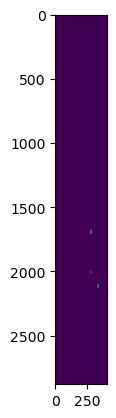

In [30]:
plt.imshow(np.squeeze(roiData.masks['veg']).astype(int))

In [31]:
roiData.df

,Name,Color,Pixel_x,Pixel_y,399.606453,401.827297,404.04814,406.268984,408.489827,410.710671,...,981.467464,983.688307,985.909151,988.129994,990.350838,992.571681,994.792525,997.013368,999.234212,1001.455055
0,veg,#fa3232,276,1679,0.086376,0.041396,-0.035162,0.132657,0.091505,0.011056,...,0.407239,0.407951,0.399352,0.396907,0.416777,0.425242,0.400042,0.393907,0.395097,0.458121
1,veg,#fa3232,277,1679,0.033315,-0.035396,0.000382,0.091226,0.005190,0.069093,...,0.445033,0.415491,0.409733,0.414909,0.425459,0.403085,0.430001,0.444321,0.410470,0.442067
2,veg,#fa3232,278,1679,0.023864,0.059560,0.076928,0.017093,0.046860,0.090927,...,0.391887,0.417891,0.444991,0.425870,0.419432,0.422098,0.449899,0.400416,0.418184,0.414755
3,veg,#fa3232,279,1679,0.034978,-0.036450,0.126887,0.069731,0.005256,0.127929,...,0.442703,0.398027,0.414919,0.409570,0.432639,0.442556,0.415080,0.396378,0.416796,0.404989
4,veg,#fa3232,280,1679,0.022667,0.142692,0.060418,0.077417,0.059828,0.018229,...,0.427030,0.415473,0.398786,0.394078,0.397418,0.362754,0.404388,0.401749,0.414610,0.406971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,veg unhealthy,#aec7e8,145,1868,0.035305,-0.026806,-0.043307,0.038671,-0.001648,0.011203,...,0.360029,0.354715,0.335806,0.354430,0.377336,0.325790,0.345330,0.333401,0.328345,0.339369
444,veg unhealthy,#aec7e8,146,1868,-0.054926,-0.034717,-0.044510,-0.028654,-0.049700,0.017008,...,0.357055,0.349846,0.348043,0.376676,0.380733,0.339815,0.305142,0.329428,0.299589,0.320145
445,veg unhealthy,#aec7e8,147,1868,0.022034,0.058081,-0.008292,-0.021280,0.045347,0.004824,...,0.352119,0.328562,0.327859,0.319382,0.303924,0.351987,0.342921,0.350934,0.328829,0.374379
446,veg unhealthy,#aec7e8,148,1868,-0.044061,0.022623,0.008968,0.041562,-0.023032,-0.027282,...,0.381126,0.314872,0.375371,0.315826,0.363749,0.363318,0.331554,0.347560,0.309191,0.340173
